In [1]:
from datetime import datetime
from PvGis import PvGis
import numpy as np
import pandas as pd
import json
import matplotlib
import rasterio
from rasterio.plot import show
import rioxarray as rxr
from osgeo import gdal
import csv
import math

In [2]:
# Create PvGis object and set its inputs
pvGis = PvGis()
pvGis.latitude = 37.097
pvGis.longitude = -2.365
pvGis.start_date = datetime(2016, 6, 1, 00, 00, 00)
pvGis.end_date = datetime(2016, 6, 15, 23, 59, 59)
pvGis.rad_database = 'PVGIS-CMSAF'

# Get data
pvGis.request_hourly_time_series()

# Save weather data to a CSV file
#pvGis.save_csv('weather_data.csv')

# Get Pandas DataFrame
df_pv = pvGis.pandas_data_frame()

In [3]:
#Read in chemical plants
df_chem = pd.read_csv('Data/chemicalparksv2.csv', sep=';', encoding='latin-1')

#Read in emissions and convert to csv
df_emissions = pd.read_json('Data/emissions.json')
co2_data = df_emissions.iloc[5,1]
co_data = df_emissions.iloc[5,2]

emissions = []

for plant in co2_data:
    emissions.append(
        {
            'FacilityName': plant['properties']['FacilityName'],
            'CountryName': plant['properties']['CountryName'],
            'ReportingYear':  plant['properties']['ReportingYear'],
            'FacilityDetails': plant['properties']['FacilityDetails'],
            'MTonnes': plant['properties']['MTonnes'],
            'Activity':  plant['properties']['NACEMainEconomicActivityName'],
            'Pollutant': plant['properties']['PollutantName'],
            'Co-ordinates':  plant['geometry']['coordinates']
            
        })
    
df_emissions = pd.DataFrame(emissions)
df_emissions.to_csv('Data/emissions.csv')

In [4]:
#Read in emissions
df_emissions = pd.read_csv('Data/emissions.csv')

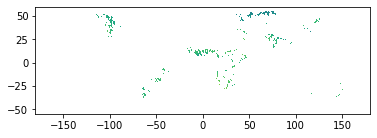

1
(13800, 43200)
EPSG:4326


In [5]:
#RasterIO read in data
fp = r'Data/global potential/derived/PVOUT_level1.tif'
dataset = rasterio.open(fp)
show(dataset)

#No. of bands
print(dataset.count)

# Image resolution
print(dataset.shape)

# Coordinate Reference System
print(dataset.crs)


In [6]:
from osgeo import gdal
g = gdal.Open('Data/global potential/derived/PVOUT_level1.tif')

#gt = tif.GetGeotransform()

x_size, y_size, n_bands = g.RasterXSize, g.RasterYSize, g.RasterCount

In [7]:
#Rioxarray to get data from tif
fp = r'Data/global potential/derived/PVOUT_level1.tif'
dataset = rxr.open_rasterio(fp)
dataset

<xarray.DataArray (band: 1, y: 13800, x: 43200)>
[596160000 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 60.0 59.99 59.98 59.97 ... -54.98 -54.99 -55.0
    spatial_ref  int32 0
Attributes: (12/260)
    COLOR_TABLE_RULES_COUNT:   255
    COLOR_TABLE_RULE_RGB_0:    0.000000e+00 2.646784e-02 68 1 84 68 2 86
    COLOR_TABLE_RULE_RGB_1:    2.646784e-02 5.293568e-02 68 2 86 69 4 87
    COLOR_TABLE_RULE_RGB_10:   2.648134e-01 2.912813e-01 71 16 99 71 17 100
    COLOR_TABLE_RULE_RGB_100:  2.647864e+00 2.674332e+00 42 118 142 42 119 142
    COLOR_TABLE_RULE_RGB_101:  2.674332e+00 2.700800e+00 42 119 142 42 120 142
    ...                        ...
    COLOR_TABLE_RULE_RGB_98:   2.594861e+00 2.621396e+00 43 116 142 43 117 142
    COLOR_TABLE_RULE_RGB_99:   2.621396e+00 2.647864e+00 43 117 142 42 118 142
    _FillValue:                nan
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 PVOUT_13_lta9418_lev1v1

In [8]:
lons = np.linspace(-180,180,361)
lats = np.linspace(-90,90,181)

count_vals = 0

lons_final = []
lats_final = []
vals = []

with rasterio.open('Data/global potential/derived/PVOUT_level1.tif') as src:    
    for i in lons:                                              #goes through every latitude for one longitude
        for j in lats:                                         #then moves onto next longitude
            for val in src.sample(zip([i], [j])):
                if val > 0 and val < 10:
                    count_vals +=1
                    lons_final.append(i)
                    lats_final.append(j)
                    vals.append(val[0]*365)
                    
vals_wind = []

with rasterio.open('Data/power_density/gwa3_250_power-density_50m.tif') as src:    
            for val in src.sample(zip(lons_final, lats_final)):
                if val > 0:
                    vals_wind.append(val[0])
                
                  
print(str(round(count_vals/(len(lons)*len(lats))*100,2)) +'%')
print(len(lons_final))


lons_lats = zip(lons_final, lats_final, vals, vals_wind)
lons_lats = tuple(lons_lats)

with open('Data/level1renewable.csv','w', newline='') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['Longitude', 'Latitude', 'Solar Energy Potential','Wind Power Density'])
    csv_out.writerows(lons_lats)

9.14%
5970


In [19]:
df_ren = pd.read_csv('Data/level1renewable.csv')
df_ren['Solar Array Size'] = 100 / df_ren['Solar Energy Potential']    #[kWp]
df_ren['Solar Array Cost'] = df_ren['Solar Array Size'] * 700    #[Eur]
df_ren['Wind Turbine Power'] = df_ren['Wind Power Density']*0.4*(50*50*math.pi)/1e6
df_ren['No. of Turbines']  = 100/df_ren['Wind Turbine Power']
df_ren['Wind Capex'] = df_ren['No. of Turbines'] * 2000000
df_ren[df_ren.loc[:, 'Longitude'] == 49.0]

,Longitude,Latitude,Solar Energy Potential,Wind Power Density,Solar Array Size,Solar Array Cost,Wind Turbine Power,No. of Turbines,Wind Capex
3927,49.0,-19.0,1573.149979,49.022762,0.063567,44.496711,0.154010,649.310388,1.298621e+09
3928,49.0,-18.0,1322.394966,44.361248,0.075620,52.934261,0.139365,717.540422,1.435081e+09
3929,49.0,-17.0,1340.645036,54.256130,0.074591,52.213672,0.170451,586.680042,1.173360e+09
3930,49.0,-13.0,1755.285006,215.078780,0.056971,39.879564,0.675690,147.996881,2.959938e+08
3931,49.0,7.0,1715.865078,256.977400,0.058280,40.795748,0.807318,123.866879,2.477338e+08
3932,49.0,8.0,1828.650084,376.417360,0.054685,38.279603,1.182550,84.563020,1.691260e+08
3933,49.0,9.0,1881.209929,415.645140,0.053157,37.210095,1.305788,76.582126,1.531643e+08
3934,49.0,10.0,1943.990078,401.240720,0.051441,36.008414,1.260535,79.331401,1.586628e+08
3935,49.0,15.0,2049.840064,139.914410,0.048784,34.149006,0.439554,227.503290,4.550066e+08
3936,49.0,24.0,1830.474951,192.661450,0.054631,38.241441,0.605264,165.217217,3.304344e+08


In [10]:
h2_demand = 1   #[kt/yr]
elec_eff = 0.81
h2_demand_hourly = h2_demand*1000*1000/(5000)
h2_demand_hourly

200.0

In [11]:
elec_demand = h2_demand_hourly * 39/elec_eff
elec_demand

9629.62962962963

In [12]:
h2_demand_hourly = h2_demand * 1000 * 1000 / 6000     #[kg/hr]
elec_demand = h2_demand_hourly * 39/0.81        #[kW]
elec_demand_yearly = h2_demand * 1000 *  39/0.81      #[MWh/yr]
elec_demand2 = elec_demand_yearly/6000
print(elec_demand)
print(elec_demand2)
print(elec_demand_yearly)

8024.691358024691
8.024691358024691
48148.148148148146


In [13]:
8024*6000

48144000